In [19]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from feature_engine import discretisation as dsc

from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import BayesianModel



from pgmpy.estimators import HillClimbSearch, MaximumLikelihoodEstimator, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [20]:
df = pd.read_csv("dataset.csv").dropna()


In [21]:
df['Sex'] = df['Sex'].replace('m',0)
df['Sex'] = df['Sex'].replace('f',1)


In [22]:
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0.0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0.0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0.0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0.0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0.0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [23]:
feature = df.drop('Category', axis=1)
target = df["Category"]

In [24]:
col_list = []
for col in feature.columns:
    print(col, ": ", len(feature[col].unique()))
    if(len(feature[col].unique()) > 32):
        col_list.append(col)

        
col_list

Age :  46
Sex :  2
ALB :  188
ALP :  409
ALT :  323
AST :  282
BIL :  187
CHE :  395
CHOL :  308
CREA :  115
GGT :  335
PROT :  194


['Age',
 'ALB',
 'ALP',
 'ALT',
 'AST',
 'BIL',
 'CHE',
 'CHOL',
 'CREA',
 'GGT',
 'PROT']

In [25]:
num_bins = 3
disc = dsc.EqualFrequencyDiscretiser(q=num_bins, variables=col_list)
df_binned = disc.fit(feature[col_list])
equalfrequency_discretizer_dict = disc.binner_dict_
bin_df_equalfrequency = pd.DataFrame.from_dict(equalfrequency_discretizer_dict, orient = 'index')

In [26]:
min(feature['Age'].unique()), max(feature['Age'].unique())
bin_age = ['19 to 28', '28 to 38', '38 to 75']

In [27]:
min(feature['ALB'].unique()), max(feature['ALB'].unique())
bin_alb = ['14 to 20', '30 to 60', '60 to 82']


In [28]:
min(feature['ALP'].unique()), max(feature['ALP'].unique())
bin_alp = ['11 to 100', '100 to 240', '240 to 400']


In [29]:
min(feature['ALT'].unique()), max(feature['ALT'].unique())
bin_alt = ['0 to 100', '100 to 200', '200 to 225']


In [30]:
min(feature['CHOL'].unique()), max(feature['CHOL'].unique())
bin_chol = ['0 to 3', '3 to 6', '6 to 10']


In [31]:
min(feature['GGT'].unique()), max(feature['GGT'].unique())
bin_ggt = ['4 to 200', '200 to 400', '400 to 550']


In [32]:
feature['Age'] = pd.cut(feature['Age'], 3, labels= bin_age)
feature['ALB'] = pd.cut(feature['ALB'], 3, labels= bin_age)
feature['ALP'] = pd.cut(feature['ALP'], 3, labels= bin_age)
feature['ALT'] = pd.cut(feature['ALT'], 3, labels= bin_age)
feature['CHOL'] = pd.cut(feature['CHOL'], 3, labels= bin_age)
feature['GGT'] = pd.cut(feature['GGT'], 3, labels= bin_age)


In [33]:
feature = pd.DataFrame([feature['Age'],feature['ALB'],feature['ALP'],feature['ALT'],df['Category']])

In [34]:
# Normalized Data

feature = feature.T

feature

,Age,ALB,ALP,ALT,Category
0,19 to 28,28 to 38,19 to 28,19 to 28,0.0
1,19 to 28,28 to 38,19 to 28,19 to 28,0.0
2,19 to 28,28 to 38,19 to 28,19 to 28,0.0
3,19 to 28,28 to 38,19 to 28,19 to 28,0.0
4,19 to 28,28 to 38,19 to 28,19 to 28,0.0
...,...,...,...,...,...
608,28 to 38,19 to 28,19 to 28,19 to 28,3.0
609,28 to 38,28 to 38,19 to 28,19 to 28,3.0
610,38 to 75,19 to 28,38 to 75,19 to 28,3.0
611,38 to 75,19 to 28,19 to 28,19 to 28,3.0


  0%|          | 4/1000000 [00:00<11:13:45, 24.74it/s]


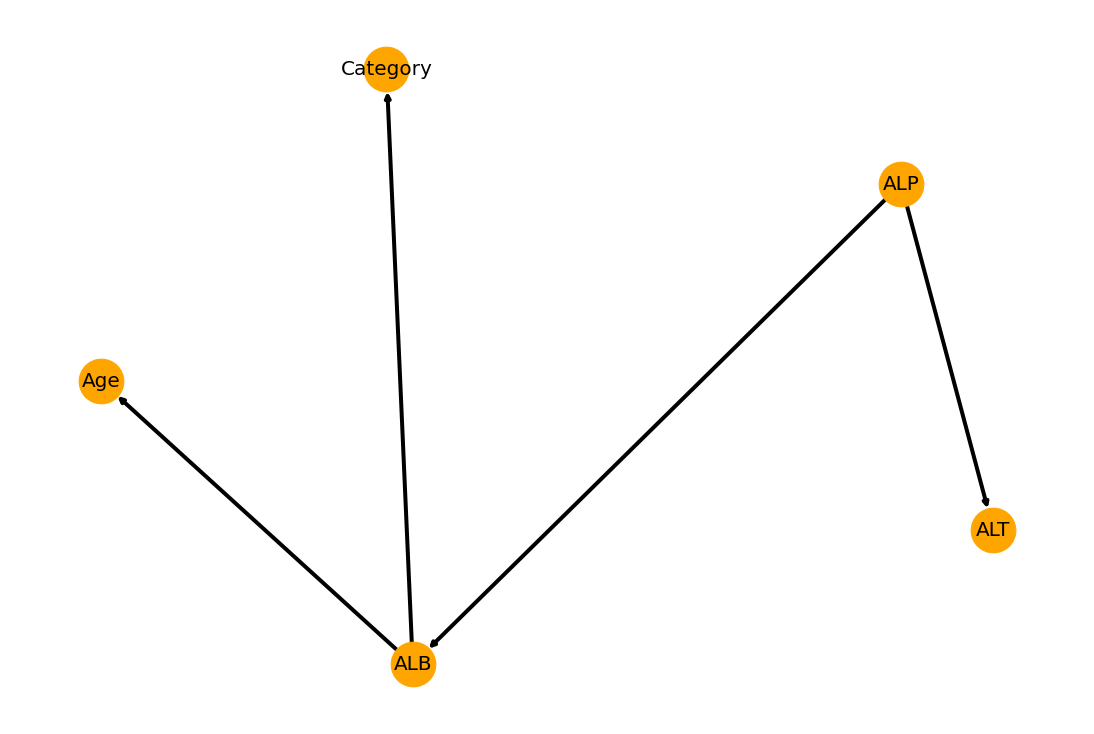

In [37]:
hc = HillClimbSearch(feature)
best_model = hc.estimate()
edges = list(best_model.edges())

model = BayesianModel(edges)

%matplotlib inline
plt.figure(figsize=(15,10))

# nx.draw(model, with_labels=True)
nx.draw(model, pos= nx.spring_layout(model), with_labels=True, node_size=2000, node_color="orange", width = 4, font_size = 20)
plt.show()

In [38]:
# Fitting the data to the model using Maximum Likelihood Estimator
model.fit(feature, estimator=MaximumLikelihoodEstimator)

# Doing exact inference using Variable Elimination
infer = VariableElimination(model)

target = 'Category'

In [39]:
model.get_parents(target)

['ALB']

In [40]:
print(infer.query(variables=[target, 'ALB'], joint= True))

Eliminating: ALP: 100%|██████████| 1/1 [00:00<00:00, 573.85it/s]

+---------------+---------------+---------------------+
| ALB           | Category      |   phi(ALB,Category) |
+===============+===============+=====================+
| ALB(19 to 28) | Category(0.0) |              0.1290 |
+---------------+---------------+---------------------+
| ALB(19 to 28) | Category(1.0) |              0.0034 |
+---------------+---------------+---------------------+
| ALB(19 to 28) | Category(2.0) |              0.0000 |
+---------------+---------------+---------------------+
| ALB(19 to 28) | Category(3.0) |              0.0340 |
+---------------+---------------+---------------------+
| ALB(28 to 38) | Category(0.0) |              0.7708 |
+---------------+---------------+---------------------+
| ALB(28 to 38) | Category(1.0) |              0.0306 |
+---------------+---------------+---------------------+
| ALB(28 to 38) | Category(2.0) |              0.0204 |
+---------------+---------------+---------------------+
| ALB(28 to 38) | Category(3.0) |              0